# BLAES Units FR Sensitivity Analysis

This notebook contains code for running a sensitivity analysis on the firing rate threshold used to identify *valid* vs. *invalid* units.

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 10/17/2024*

## 1. Import Libraries

In [1]:
import os
import re
import glob
import datetime
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, norm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap
from IPython.display import clear_output

In [2]:
# Display params
%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Export
export = True

thresholds = np.arange(0, 3.1, .1)

## 2. Load Data

In [3]:
# Define path
resultsDir = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/Results/'

allSpikeInfo = pd.read_csv(os.path.join(resultsDir, 'Group', 'allSpikeInfo.csv'), index_col=0)
statsDF = pd.read_csv(os.path.join(resultsDir, 'Group', 'SpikeStats.csv'), index_col=0)
nUnits = statsDF.shape[0]

## 3. Run Sensitivity Analysis
Takes a long time to compute.

In [ ]:
nPerms = 1000
stim_statsDFs = []
nostim_statsDFs = []

for condition in ['Stim', 'No-Stim']:

    for thresh in thresholds:
        print('Threshold:', thresh)
        clear_output(wait=True)
        
        # Holders for dataframe
        statsPrePost = []
        statsPreDuring = []
        pValsPrePost = []
        pValsPreDuring = []
        pValsPrePostPerm = []
        pValsPreDuringPerm = []
        resultsPrePostPerm = []
        resultsPreDuringPerm = []
        permHolderPrePost = []
        permHolderPreDuring = []
        unitLabels = []
        pIDLabels = []
        validity = []
        laterality = []
        regions = []
        preFRs = []
        duringFRs = []
        postFRs = []

        for pID in allSpikeInfo['pID'].unique():
            pIDSpikes = allSpikeInfo[(allSpikeInfo['pID'] == pID) & (allSpikeInfo['Condition'] == condition)]
            pIDSpikes.reset_index(drop=True, inplace=True)
            for unit in pIDSpikes['Unit'].unique():
                unitDF = pIDSpikes[pIDSpikes['Unit'] == unit]
                
                # OVERWRITE VALIDITY CHECK
                unitDF.loc[:, 'Valid'] = False
                if unitDF['ISI'].mean() >= thresh:
                    unitDF.loc[:, 'Valid'] = True
                
                # Run stats on valid units
                if unitDF['Valid'].iloc[0] == True:
                    try:
                        statPrePost, pPrePost = wilcoxon(unitDF['Post'], unitDF['ISI'])
                    except:
                        statPrePost = np.nan
                        pPrePost = np.nan
                    try:
                        statPreDuring, pPreDuring = wilcoxon(unitDF['During'], unitDF['ISI'])
                    except:
                        statPreDuring = np.nan
                        pPreDuring = np.nan

                    # Permutation testing
                    permStatsPrePost = []
                    permStatsPreDuring = []
                    np.random.seed(0)
                    
                    # Pre- vs. Post-stim
                    for i in range(nPerms):
                        permDF = unitDF[['ISI', 'Post']].copy().melt(var_name = 'Epoch', value_name = 'Spike')
                        epochLabels = permDF['Epoch']
                        epochLabels = np.random.permutation(epochLabels)
                        permDF['Epoch'] = epochLabels
                        preSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
                        postSpikes = permDF[permDF['Epoch'] == 'Post']['Spike']
                        
                        try:
                            permStatPrePost, _ = wilcoxon(postSpikes.values, preSpikes.values)
                        except:
                            permStatPrePost = np.nan
                        permStatsPrePost.append(permStatPrePost)
                    permHolderPrePost.append(permStatsPrePost)
                    
                    # Pre- vs. During-stim
                    for i in range(nPerms):
                        permDF = unitDF[['ISI', 'During']].copy().melt(var_name = 'Epoch', value_name = 'Spike')
                        epochLabels = permDF['Epoch']
                        epochLabels = np.random.permutation(epochLabels)
                        permDF['Epoch'] = epochLabels
                        preSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
                        duringSpikes = permDF[permDF['Epoch'] == 'During']['Spike']
                        
                        try:
                            permStatPreDuring, _ = wilcoxon(duringSpikes.values, preSpikes.values)
                        except:
                            permStatPreDuring = np.nan
                        permStatsPreDuring.append(permStatPreDuring)
                    permHolderPreDuring.append(permStatsPreDuring)
                        
                    # Compute p-values using z-score method(from permutation distribution)
                    zPrePostPerm = (statPrePost - np.mean(permStatsPrePost)) / np.std(permStatsPrePost)
                    pPrePostPerm = norm.sf(abs(zPrePostPerm)) * 2
                    if pPrePostPerm < 0.05:
                        resultsPrePostPerm.append(True)
                    else:
                        resultsPrePostPerm.append(False)
                        
                    zPreDuringPerm = (statPreDuring - np.mean(permStatsPreDuring)) / np.std(permStatsPreDuring)
                    pPreDuringPerm = norm.sf(abs(zPreDuringPerm)) * 2
                    if pPreDuringPerm < 0.05:
                        resultsPreDuringPerm.append(True)
                    else:
                        resultsPreDuringPerm.append(False)
                    
                # If unit is invalid
                else:
                    statPrePost = np.nan
                    statPreDuring = np.nan
                    pPrePost = np.nan
                    pPreDuring = np.nan
                    pPrePostPerm = np.nan
                    pPreDuringPerm = np.nan
                    resultsPrePostPerm.append(np.nan)
                    resultsPreDuringPerm.append(np.nan)
                    permHolderPrePost.append(np.nan)
                    permHolderPreDuring.append(np.nan)
                
                # Append to holders
                statsPrePost.append(statPrePost)
                statsPreDuring.append(statPreDuring)
                pValsPrePost.append(pPrePost)
                pValsPreDuring.append(pPreDuring)
                pValsPrePostPerm.append(pPrePostPerm)
                pValsPreDuringPerm.append(pPreDuringPerm)
                unitLabels.append(unit)
                pIDLabels.append(pID)
                validity.append(unitDF['Valid'].iloc[0])
                laterality.append(unitDF['Ipsilateral'].iloc[0])
                regions.append(unitDF['Region'].iloc[0])
                preFRs.append(unitDF['ISI'].mean())
                duringFRs.append(unitDF['During'].mean())
                postFRs.append(unitDF['Post'].mean())
                
        # Construct dataframe
        statsDF = pd.DataFrame({'pID': pIDLabels, 'Unit': unitLabels, 'Region': regions, 'Ipsilateral': laterality, 'Valid': validity, 'Pre': preFRs, 'During': duringFRs, 'Post': postFRs, 'Stat_PrePost': statsPrePost, 'Stat_PreDuring': statsPreDuring, 'pVal_PrePost': pValsPrePost, 'pVal_PreDuring': pValsPreDuring, 'pVal_PrePost_Perm': pValsPrePostPerm, 'pVal_PreDuring_Perm': pValsPreDuringPerm, 'PermSig_PrePost': resultsPrePostPerm, 'PermSig_PreDuring': resultsPreDuringPerm,'PermStats_PrePost': permHolderPrePost, 'PermStats_PreDuring': permHolderPreDuring})

        # Add column for significant results w/ permutation testing
        statsDF['Sig'] = (statsDF['PermSig_PrePost'] == True) | (statsDF['PermSig_PreDuring'] == True)
        
        # Append to list
        if condition == 'Stim':
            statsDF['Condition'] = 'Stim'
            stim_statsDFs.append(statsDF)
        elif condition == 'No-Stim':
            statsDF['Condition'] = 'No-Stim'
            nostim_statsDFs.append(statsDF)
            
all_statsDFs = pd.concat(stim_statsDFs + nostim_statsDFs)

# Export results
all_statsDFs.to_csv(os.path.join(resultsDir, 'Group', 'SensitivitytAnalysisStats.csv'))

In [ ]:
condHolder = []

for i, statsDFs in enumerate([stim_statsDFs, nostim_statsDFs]):
    totalValid = []
    totalSig = []
    percentValid = []
    percentSig = []
    for statsDF in statsDFs:
        statsDFValid = statsDF[statsDF['Valid'] == True]
        totalValid.append(statsDFValid.shape[0])
        totalSig.append(statsDFValid['Sig'].sum())
        percentValid.append(statsDF['Valid'].mean() * 100)
        percentSig.append(statsDFValid['Sig'].mean() * 100)
        
    if i == 0:
        condition = 'Stim'
    else:
        condition = 'No-Stim'
        
    # Construct dataframe
    summaryDF = pd.DataFrame({'Threshold': thresholds, 'TotalValid': totalValid, 'TotalSig': totalSig, 'PercentValid': percentValid, 'PercentSig': percentSig})
    summaryDF['Condition'] = condition
    condHolder.append(summaryDF)
    
sensitivityDF = pd.concat(condHolder)

# Export results
sensitivityDF.to_csv(os.path.join(resultsDir, 'Group', 'SensitivityAnalysisSummary.csv'))

## 4. Visualize Results

In [4]:
sensitivityDF = pd.read_csv(os.path.join(resultsDir, 'Group', 'SensitivityAnalysisSummary.csv'), index_col=0)
sensitivity_stim = sensitivityDF[sensitivityDF['Condition'] == 'Stim']
sensitivity_nostim = sensitivityDF[sensitivityDF['Condition'] == 'No-Stim']
avg_valid = (sensitivity_stim['PercentValid'] + sensitivity_nostim['PercentValid']) / 2

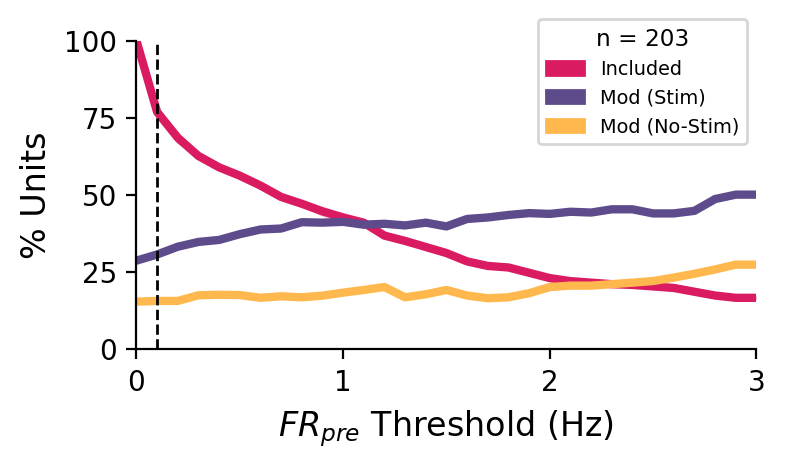

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (4, 2))
plotPal = ['#da1b61', '#5e4b8b', '#ffb84d']
lw = 3

sns.lineplot(data = sensitivityDF, x = 'Threshold', y = 'PercentValid', color = plotPal[0], lw = lw, ax = ax1)
sns.lineplot(data = sensitivity_stim, x = 'Threshold', y = 'PercentSig', color = plotPal[1], lw = lw, ax = ax1)
sns.lineplot(data = sensitivity_nostim, x = 'Threshold', y = 'PercentSig', color = plotPal[2], lw = lw, ax = ax1)

# Figure aeshtetics
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1]), Rectangle((0, 0), 1, 1, color = plotPal[2])]
plt.legend(title = 'n = %i' %nUnits, handles = handles, labels = ['Included', 'Mod (Stim)', 'Mod (No-Stim)'], title_fontsize = 'small', fontsize = 'x-small', bbox_to_anchor = (1, 1.1))

for ax in [ax1]:
    ax.axvline(0.1, color = 'k', linestyle = '--', lw = 1, zorder = 5)
    ax.set_xticks(np.arange(0, 4, 1))
    ax.set_xlim([0, 3])
    ax.set_xlabel('$FR_{pre}$ Threshold (Hz)', fontsize = 'large')

ax1.set_ylabel('% Units', fontsize = 'large')
ax1.set_yticks(np.arange(0, 125, 25))
ax1.set_ylim([0, 100])
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'SensitivityAnalysis.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()